## DS

In [19]:
from PIL import Image
import numpy as np
import cv2
import scipy.interpolate as interp

def depth_image_to_numpy(image_path):
    try:
        # 打开图像
        image = Image.open(image_path)

        # 将图像转换为灰度模式
        grayscale_image = image.convert('L')

        # 将图像转换为NumPy数组
        depth_array = np.array(grayscale_image)

        return depth_array
    except FileNotFoundError:
        print(f"错误: 文件 {image_path} 未找到。")
    except Exception as e:
        print(f"发生未知错误: {e}")
    return None



In [10]:
image_path = 'test_depth.png'
depth_array = depth_image_to_numpy(image_path)
print(f"数据形状{depth_array.shape}； 亮度范围 from: {depth_array.min()} to {depth_array.max()}")
print(f"H,W即图像形状：{depth_array.shape}")

数据形状(1536, 2048)； 亮度范围 from: 0 to 254
H,W即图像形状：(1536, 2048)


In [ ]:
# 将其归一化，恢复为0-30m，然后进行插值
depth = (depth_array / 255 * 30)

max_depth = np.max(depth)
boundaries = np.arange(0.5, max_depth + 0.5, 0.5)

merged_depth = np.copy(depth)
mask_processed = np.zeros_like(depth, dtype=bool)


In [ ]:
image_H, image_W = depth.shape

# 按分界面由近到远处理每个区间
for z_max_i in boundaries:
    z_prev = z_max_i - 0.5
    # 提取当前区间的点，且未被处理过的区域
    mask_i = (depth >= z_prev) & (depth < z_max_i) & (~mask_processed)
    if np.sum(mask_i) == 0:
        continue  # 没有点则跳过

    # 提取当前层的点云坐标和深度值
    y_indices, x_indices = np.where(mask_i)
    points = np.column_stack((x_indices, y_indices))  # (x, y)格式
    values = depth[mask_i]

    # 生成网格坐标
    grid_x, grid_y = np.meshgrid(np.arange(image_W), np.arange(image_H))

    # 线性插值
    grid_z = interp.griddata(points, values, (grid_x, grid_y), method='linear')

    # 确定有效区域（非NaN且未被处理过）
    valid_mask = ~np.isnan(grid_z) & (~mask_processed)

    # 更新合并后的深度图和掩膜
    merged_depth[valid_mask] = grid_z[valid_mask]
    mask_processed |= valid_mask
# 将未被处理的区域保留为原深度值（例如超出最后一个分界面或插值未覆盖）
remaining_mask = ~mask_processed
merged_depth[remaining_mask] = depth[remaining_mask]

## DB

In [23]:
import numpy as np
from PIL import Image
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.tri import LinearTriInterpolator,Triangulation

image_path = 'test_depth.png'
max_depth = 30
DEBUG = True

image = Image.open(image_path)
depth_map = (np.array(image)) / 255.0 * max_depth

H, W = depth_map.shape
max_depth = np.max(depth_map)  # 最大深度
depth_bins = np.arange(0.01, max_depth + 0.51, 0.5)  # 分界面，左闭右开区间 去除掉为0的无点云区域
num_bins = len(depth_bins) - 1  # 区间数量
mask = np.zeros((H, W), dtype=bool)  # 近景处理标记mask
final_depth = np.zeros_like(depth_map, dtype=np.float32)  # 最终深度图

In [ ]:

# 按深度处理
for i in range(num_bins):
    low = depth_bins[i]
    high = depth_bins[i + 1]
    
    # 筛选当前区间内未被近景处理的点
    valid_mask = (depth_map >= low) & (depth_map < high) & (~mask)
    if not np.any(valid_mask):
        print(f"No valid points found in depth bin {i} with depth range {low} - {high}")# 经过测试，直到3.51才开始有深度点
        continue  # 无有效点，跳过
    
    u, v = np.where(valid_mask)  # 像素坐标（行、列，需根据坐标系调整）
    depths = depth_map[valid_mask]  # 对应深度值
    
    # 生成当前分界面的2D图像（仅有效点有值）
    interface = np.full((H, W), np.nan, dtype=np.float32)
    interface[u, v] = depths
    # 转换为 Delaunay 所需的坐标格式（假设图像坐标系为(u, v)=(行, 列)）
    points = np.column_stack((v, u))  # (x, y) = (列, 行)
    
    if False:
        # 保存剖分前的数组
        pre_triangulation = np.full((H, W), np.nan, dtype=np.float32)
        pre_triangulation[u, v] = depths
        # 可视化剖分前的数组
        plt.figure()
        plt.imshow(pre_triangulation, cmap='gray')
        plt.title(f'Pre - Triangulation (Bin {i})')
        plt.colorbar()
        plt.show()
    
    tri_scipy = Delaunay(points) # 三角剖分
    triangles = tri_scipy.simplices  # 获取三角形顶点索引
    tri_mpl = Triangulation(points[:, 0], points[:, 1], triangles=triangles)
    tri_interp = LinearTriInterpolator(tri_mpl, depths)
    
    # 生成网格坐标（覆盖整个图像）
    grid_v, grid_u = np.meshgrid(np.arange(W), np.arange(H)) # 生成网格坐标
    interpolated = tri_interp(grid_v.ravel(), grid_u.ravel()) 
    # interpolated = tri_interp(grid_v.ravel(), grid_u.ravel())  # 关键修改：直接调用插值器

    # grid_points = np.column_stack((grid_v.ravel(), grid_u.ravel()))  # (N, 2) N=H*W
    
    # # 线性插值（利用三角剖分的顶点深度）
    # interpolated = np.zeros(grid_points.shape[0], dtype=np.float32)# (N,)
    # simplex_indices = tri_scipy.find_simplex(grid_points)
    # # for j, triangle in enumerate(tri_scipy.simplices):# j 是第几个三角形;triangle是面片，含三个顶点
    # #     # 三角形三个顶点的索引
    # #     v0, u0 = points[triangle[0]]
    # #     v1, u1 = points[triangle[1]]
    # #     v2, u2 = points[triangle[2]]
    # #     d0, d1, d2 = depths[triangle] # depths中按索引顺序存储了每个点的亮度值 即深度值

    # #     mask_tri = simplex_indices == j
    # #     # mask_tri = tri.point_in_simplex(grid_points, j) >= 0  # 点是否在第j个三角形内
    # #     interpolated[mask_tri] = np.interp(
    # #         grid_points[mask_tri], 
    # #         (points[triangle],), 
    # #         (d0, d1, d2)
    # #     )
    
    # 重塑为图像尺寸
    interpolated_image = interpolated.reshape((H, W))
    
    if DEBUG:
        # 可视化剖分后的数组
        plt.figure()
        plt.imshow(interpolated_image, cmap='gray')
        plt.title(f'Post - Triangulation (Bin {i})')
        plt.colorbar()
        # plt.savefig(f'post_triangulation_bin_{i}.png')
        # plt.close()
        plt.show()
    
    # 更新mask和最终深度图
    mask = mask | valid_mask
    final_depth[valid_mask] = interpolated_image[valid_mask]


# 处理未覆盖区域（用原始深度填充）
final_depth[np.isnan(final_depth)] = depth_map[np.isnan(final_depth)]


In [ ]:
from sklearn.cluster import DBSCAN  # 导入聚类模块

# 按深度处理
for i in range(num_bins):
    low = depth_bins[i]
    high = depth_bins[i + 1]
    
    # 筛选当前区间内未被近景处理的点
    valid_mask = (depth_map >= low) & (depth_map < high) & (~mask)
    if not np.any(valid_mask):
        print(f"No valid points found in depth bin {i} with depth range {low} - {high}")
        continue  # 无有效点，跳过
    
    u, v = np.where(valid_mask)  # 像素坐标（行、列）
    depths = depth_map[valid_mask]  # 对应深度值
    
    # 生成当前分界面的2D图像（仅有效点有值）
    interface = np.full((H, W), np.nan, dtype=np.float32)
    interface[u, v] = depths
    points = np.column_stack((v, u))  # (x, y) = (列, 行)

    if len(points) < 3:  # 点不足3个，无法剖分
        continue
    
    # 使用DBSCAN聚类，调整eps和min_samples参数
    db = DBSCAN(eps=5, min_samples=3).fit(points)  # 参数需根据数据调整
    labels = db.labels_
    unique_clusters = np.unique(labels)
    
    # 初始化当前深度层的插值结果
    current_interpolated = np.full((H, W), np.nan, dtype=np.float32)
    
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # 噪声点
            continue
        
        # 提取当前簇的点和深度值
        cluster_mask = (labels == cluster_id)
        cluster_points = points[cluster_mask]
        cluster_depths = depths[cluster_mask]
        
        if len(cluster_points) < 3:
            print(f"No valid points found in cluster {cluster_id}")
            continue  # 簇点不足，跳过
        
        # 三角剖分和插值
        tri = Delaunay(cluster_points)
        tri_mpl = Triangulation(cluster_points[:, 0], cluster_points[:, 1], triangles=tri.simplices)
        tri_interp = LinearTriInterpolator(tri_mpl, cluster_depths)
        
        # 生成网格坐标（覆盖整个图像）
        grid_v, grid_u = np.meshgrid(np.arange(W), np.arange(H))
        grid_points = np.dstack((grid_v, grid_u))[0]  # (H, W, 2)
        
        # 插值整个网格
        interpolated_cluster = tri_interp(grid_v, grid_u)
        interpolated_cluster = interpolated_cluster.reshape((H, W))
        
        # 合并到当前层的插值结果（保留非NaN区域）
        valid_cluster = ~np.isnan(interpolated_cluster)
        current_interpolated[valid_cluster] = interpolated_cluster[valid_cluster]
    
    # -----------------------------------
    # 新增：合并所有插值结果到 final_depth
    # -----------------------------------
    # 更新最终深度图（覆盖所有有效区域）
    valid_interpolated = ~np.isnan(current_interpolated)
    final_depth[valid_interpolated] = current_interpolated[valid_interpolated]
    
    # 更新掩码（标记所有有效区域为已处理）
    mask |= valid_interpolated
    
    if DEBUG:
        # 可视化当前层的插值结果
        plt.figure()
        plt.imshow(current_interpolated, cmap='gray')
        plt.title(f'Post - Clustering & Triangulation (Bin {i})')
        plt.colorbar()
        plt.show()

# 处理未覆盖区域（用原始深度填充）
final_depth[np.isnan(final_depth)] = depth_map[np.isnan(final_depth)]

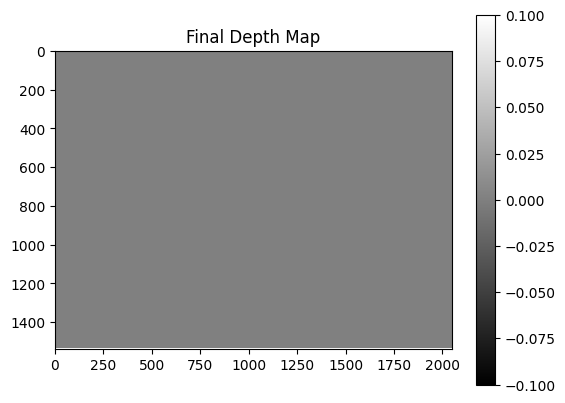

In [26]:
plt.figure()
plt.imshow(final_depth, cmap='gray')
plt.title('Final Depth Map')
plt.colorbar()
plt.show()

## 已知可以使用的 深度三角剖分

In [3]:
import numpy as np
from PIL import Image
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.tri import LinearTriInterpolator,Triangulation

image_path = 'test_depth.png'
max_depth = 30
DEBUG = True

image = Image.open(image_path)
depth_map = (np.array(image)) / 255.0 * max_depth

H, W = depth_map.shape
max_depth = np.max(depth_map)  # 最大深度
depth_bins = np.arange(0.01, max_depth + 0.51,10)  # 分界面，左闭右开区间 去除掉为0的无点云区域
num_bins = len(depth_bins) - 1  # 区间数量
mask = np.zeros((H, W), dtype=bool)  # 近景处理标记mask
final_depth = np.zeros_like(depth_map, dtype=np.float32)  # 最终深度图

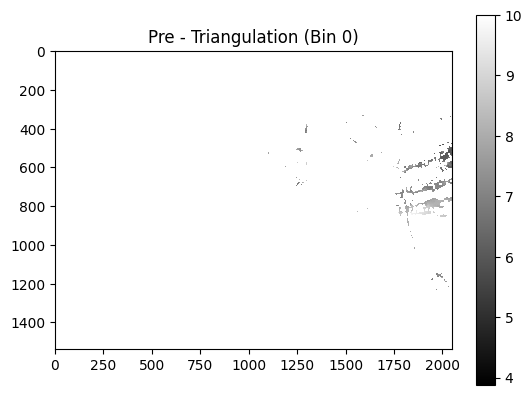

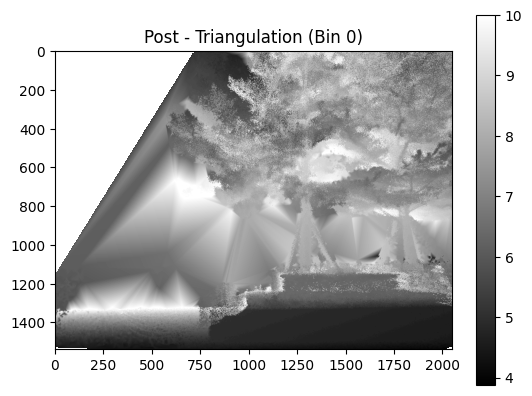

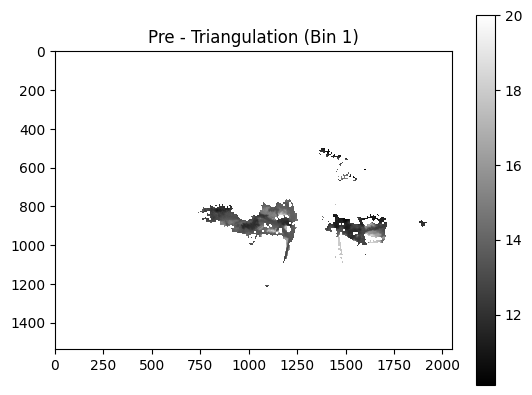

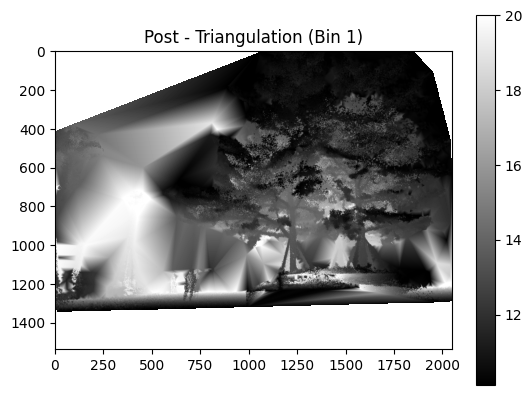

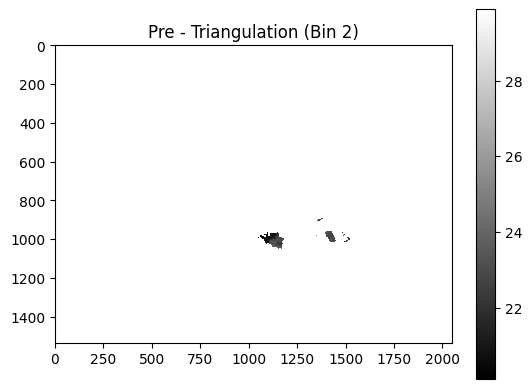

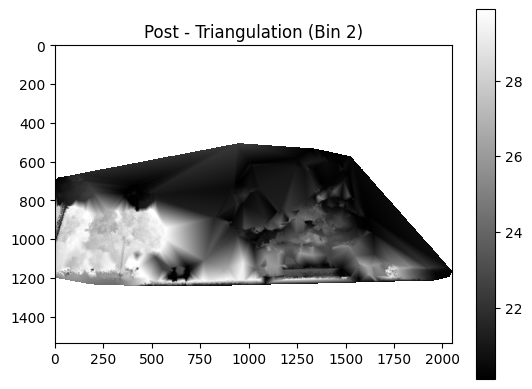

In [4]:
# 按深度处理
for i in range(num_bins):
    low = depth_bins[i]
    high = depth_bins[i + 1]
    
    # 筛选当前区间内未被近景处理的点
    valid_mask = (depth_map >= low) & (depth_map < high) & (~mask)
    if not np.any(valid_mask):
        print(f"No valid points found in depth bin {i} with depth range {low} - {high}")# 经过测试，直到3.51才开始有深度点
        continue  # 无有效点，跳过
    
    u, v = np.where(valid_mask)  # 像素坐标（行、列，需根据坐标系调整）
    depths = depth_map[valid_mask]  # 对应深度值
    
    # 生成当前分界面的2D图像（仅有效点有值）
    interface = np.full((H, W), np.nan, dtype=np.float32)
    interface[u, v] = depths
    # 转换为 Delaunay 所需的坐标格式（假设图像坐标系为(u, v)=(行, 列)）
    points = np.column_stack((v, u))  # (x, y) = (列, 行)
    
    if DEBUG:
        # 保存剖分前的数组
        pre_triangulation = np.full((H, W), np.nan, dtype=np.float32)
        pre_triangulation[u, v] = depths
        # 可视化剖分前的数组
        plt.figure()
        plt.imshow(pre_triangulation, cmap='gray')
        plt.title(f'Pre - Triangulation (Bin {i})')
        plt.colorbar()
        plt.show()
    
    tri_scipy = Delaunay(points) # 三角剖分
    triangles = tri_scipy.simplices  # 获取三角形顶点索引
    tri_mpl = Triangulation(points[:, 0], points[:, 1], triangles=triangles)
    tri_interp = LinearTriInterpolator(tri_mpl, depths)
    
    # 生成网格坐标（覆盖整个图像）
    grid_v, grid_u = np.meshgrid(np.arange(W), np.arange(H)) # 生成网格坐标
    interpolated = tri_interp(grid_v.ravel(), grid_u.ravel()) 

    # 重塑为图像尺寸
    interpolated_image = interpolated.reshape((H, W))
    
    if DEBUG:
        # 可视化剖分后的数组
        plt.figure()
        plt.imshow(interpolated_image, cmap='gray')
        plt.title(f'Post - Triangulation (Bin {i})')
        plt.colorbar()
        # plt.savefig(f'post_triangulation_bin_{i}.png')
        # plt.close()
        plt.show()
    
    # 更新mask和最终深度图
    mask = mask | valid_mask
    final_depth[valid_mask] = interpolated_image[valid_mask]


# 处理未覆盖区域（用原始深度填充）
final_depth[np.isnan(final_depth)] = depth_map[np.isnan(final_depth)]

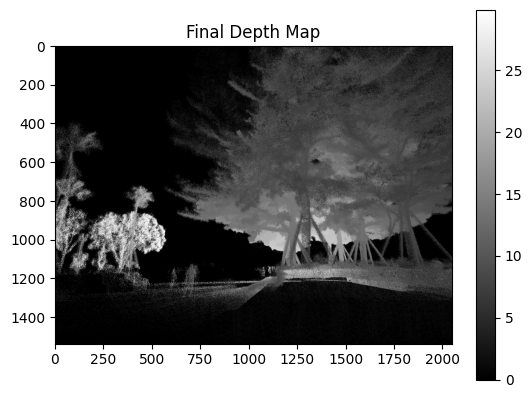

In [5]:
plt.figure()
plt.imshow(final_depth, cmap='gray')
plt.title('Final Depth Map')
plt.colorbar()
plt.show()